In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [36]:
tdc = pd.read_csv('data_sets/wr_tdc_new.csv')

tdc['cfb conference'] = tdc['cfb conference'].fillna('Other')
tdc['cfb class'] = tdc['cfb class'].fillna('Non Declared')

#tdc = tdc.fillna(0)

In [37]:
columns_floats = list(range(13,21)) +list(range(26,53)) +list(range(60,73)) +list(range(75,83)) + [85,92,93]
tdc_floats = tdc.iloc[:,columns_floats]
tdcf = tdc_floats.corr(method='pearson')

columns_nonnum = ['cfb conference','cfb class']

### Warning:

Considering our table, we realize that:
- 300 out of 393 rows have complete data,
- 31+10+30 = 71 rows with either cfb or combine stats,
- and 22 have neither of those.

In [38]:
pd.crosstab(tdc['cfb method'], tdc['combine method'])

combine method,fail after search (missing link),fail after search (missing table),success from merge
cfb method,,,
fail (eg link broken),8,14,31
success,10,30,300


# Metrics of Interest

In [39]:
tdcf.iloc[ list(range(0,35))+[57,58] , list(range(35,57)) ].sum(axis = 1).sort_values(ascending = False)[:5]

nfl receptions per game    3.302019
nfl rec yards per game     3.235976
seasons above thresh       2.989721
yards first 5 seasons      2.931439
nfl game started           2.895857
dtype: float64

From simply looking at the correlation matrix, we search for targets that have the most (on average) correlation with the rest of the cfb and combine data. The result is 3 potential targets. We plot the correlation matrix as a heatmap, similarly that we did in the Exploratory_data notebook. We also look at the impact the nonnumerical factors have on our metrics

In [33]:
possible_targets = ['nfl receptions per game', 'nfl rec yards per game', 'yards first 5 seasons']

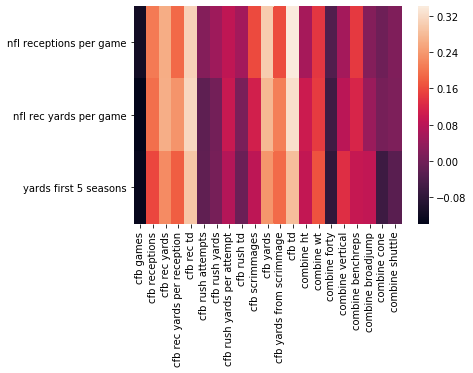

In [99]:
f = sns.heatmap(tdcf.loc[possible_targets ,'cfb games':'combine shuttle'], annot=False)

In [101]:
fig = f.get_figure()
fig.savefig('corr.png',dpi = 800)

In [35]:
tdcf.loc[ possible_targets ,'cfb games':'combine shuttle' ].sum(axis = 0).sort_values(ascending = True)

cfb games                     -0.383669
combine forty                 -0.170747
combine cone                  -0.056463
cfb rush attempts             -0.019556
combine shuttle                0.004048
cfb rush td                    0.059197
cfb rush yards                 0.059225
combine broadjump              0.158227
combine ht                     0.252443
cfb rush yards per attempt     0.259819
combine vertical               0.269236
cfb scrimmages                 0.355447
combine benchreps              0.356856
combine wt                     0.453550
cfb receptions                 0.560132
cfb yards from scrimmage       0.568272
cfb rec yards per reception    0.604517
cfb rec yards                  0.753171
cfb yards                      0.813314
cfb rec td                     0.918385
cfb td                         0.950322
dtype: float64

It seems like cfb rush attemps have the least impact on our 3 targets, while cfb rec td has the most. We'll be using these two metrics and test them out to see if they truly influence any of our targets.
- cfb rush attempts
- cfb rec td

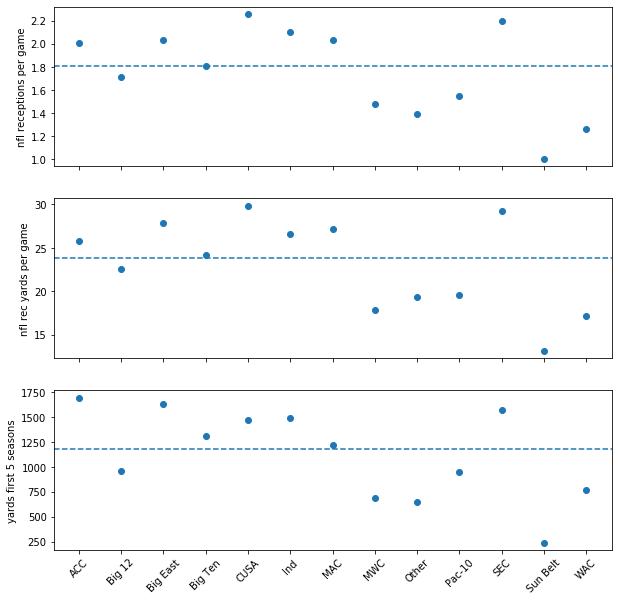

In [102]:
fig, axs = plt.subplots(3,1,figsize = (10,10), sharex=True, sharey=False)

k = 0
axs[k].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]], marker = 'o', linestyle = '')
axs[k].set_ylabel(possible_targets[k])
axs[k].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

k = 1
axs[k].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]], marker = 'o', linestyle = '')
axs[k].set(ylabel=possible_targets[k])
axs[k].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

k = 2
axs[k].plot(tdc.groupby(['cfb conference']).mean()[possible_targets[k]], marker = 'o', linestyle = '')
axs[k].set(ylabel=possible_targets[k])
axs[k].axhline(tdc[possible_targets[k]].mean(), linestyle = '--')

plt.setp(axs[2].get_xticklabels(), rotation=45)
plt.show()

In [105]:
fig.savefig('conf.png')

In [154]:
print('The means of our metrics are:\n',tdc[possible_targets].mean())

display(tdc.groupby(['cfb class'])[possible_targets].agg(['count','mean']).sort_values(by = (possible_targets[0],'mean'), ascending = False))


The means of our metrics are:
 nfl receptions per game       1.489313
nfl rec yards per game       19.660051
yards first 5 seasons      1184.254453
dtype: float64


nfl receptions per game           nfl rec yards per game  \
                               count      mean                  count   
cfb class                                                               
SO                                 8  3.375000                      8   
JR                                56  2.446429                     56   
SR                               244  1.327459                    244   
Non Declared                      84  1.159524                     84   
FR                                 1  0.000000                      1   

                        yards first 5 seasons               
                   mean                 count         mean  
cfb class                                                   
SO            43.625000                     8  3021.875000  
JR            33.530357                    56  2200.017857  
SR            17.195492                   244  1013.405738  
Non Declared  15.523810                    84   842.440476  
FR             0.000000                     1     0.000000

# Running stat tests on target vs input

After narrowing down our study to a few targets, we will run statistical tests on our key inputs which we believe have an impact (positive or negative) on the target:
- 1) SEC vs Big 12 (via bootsrap)
- 2) cfb rush attempts (via scipytests ttest_ind)
- 3) cfb rec td (via scipy test, ttest_ind with equal_var = False)

### Test1: SEC vs Big 12 - Bootstrap

In [68]:
def bs_replicate_1d(array, func):
    return func(np.random.choice(array, len(array)))

def bootstraps(array, func, size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(array, func)
        
    return bs_replicates

def main(target, N_rep):
    sec = tdc[tdc['cfb conference'] == 'SEC'][target].dropna()
    big12 = tdc[tdc['cfb conference'] == 'Big 12'][target].dropna()

    mean_diff = np.mean(sec) - np.mean(big12)
    conc = np.concatenate((sec,big12))
    mean_conc = np.mean(conc)
    sec_shifted = sec - np.mean(sec) + mean_conc
    big12_shift = big12 - np.mean(big12) + mean_conc

    bs_rep_sec = bootstraps(sec_shifted, np.mean, N_rep)
    bs_rep_big12 = bootstraps(big12_shift, np.mean, N_rep)
    bs_rep_diff = bs_rep_sec - bs_rep_big12

    p = np.sum(bs_rep_diff > mean_diff)/len(bs_rep_diff)
    return p, np.mean(sec), np.mean(big12)

In [69]:
i = 0
X = main(possible_targets[i], 10000)
print('The p value for the hypothesis SEC and Big12 are from the same distribution w.r.t \nto %s is: \np = %f' 
      %(possible_targets[i], X[0]))
print('given that the means for each sample is: SEC - %.4f and Big12 - %.4f' %(X[1],X[2]) )

The p value for the hypothesis SEC and Big12 are from the same distribution w.r.t 
to nfl receptions per game is: 
p = 0.062900
given that the means for each sample is: SEC - 2.1938 and Big12 - 1.7156


In [70]:
i = 1
X = main(possible_targets[i], 10000)
print('The p value for the hypothesis SEC and Big12 are from the same distribution w.r.t \nto %s is: \np = %f' 
      %(possible_targets[i], X[0]))
print('given that the means for each sample is: SEC - %.4f and Big12 - %.4f' %(X[1],X[2]) )

The p value for the hypothesis SEC and Big12 are from the same distribution w.r.t 
to nfl rec yards per game is: 
p = 0.063700
given that the means for each sample is: SEC - 29.2792 and Big12 - 22.5750


In [71]:
i = 2
X = main(possible_targets[i], 10000)
print('The p value for the hypothesis SEC and Big12 are from the same distribution w.r.t \nto %s is: \np = %f' 
      %(possible_targets[i], X[0]))
print('given that the means for each sample is: SEC - %.4f and Big12 - %.4f' %(X[1],X[2]) )

The p value for the hypothesis SEC and Big12 are from the same distribution w.r.t 
to yards first 5 seasons is: 
p = 0.021300
given that the means for each sample is: SEC - 1573.8305 and Big12 - 961.3023


### Test2: CFB Rush Attempts - Scipytest

Let's consider the set of players below and above the mean.

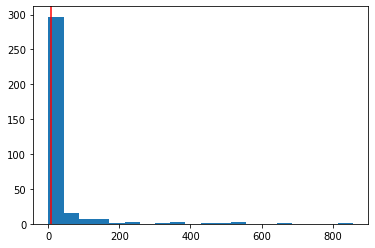

In [64]:
_ = plt.hist(tdc['cfb rush attempts'], bins = 20)
_ = plt.axvline(tdc['cfb rush attempts'].median(), color = 'r')

In [63]:
i = 0
cfbra_low = tdc[tdc['cfb rush attempts'] < tdc['cfb rush attempts'].median()][possible_targets[i]].dropna()
cfbra_high = tdc[tdc['cfb rush attempts'] >= tdc['cfb rush attempts'].median()][possible_targets[i]].dropna()
X = scipy.stats.ttest_ind(cfbra_low, cfbra_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb rush attempts'+
      '\nbelow and above the mean are from the same distribution'+
      '\nw.r.t. %s' %possible_targets[i]+
      '\nThe p-test for such hypothesis is p = %.4f \n' %X[1])


i = 1
cfbra_low = tdc[tdc['cfb rush attempts'] < tdc['cfb rush attempts'].median()][possible_targets[i]].dropna()
cfbra_high = tdc[tdc['cfb rush attempts'] >= tdc['cfb rush attempts'].median()][possible_targets[i]].dropna()
X = scipy.stats.ttest_ind(cfbra_low, cfbra_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb rush attempts'+
      '\nbelow and above the mean are from the same distribution'+
      '\nw.r.t. %s' %possible_targets[i]+
      '\nThe p-test for such hypothesis is p = %.4f \n' %X[1])

i = 2
cfbra_low = tdc[tdc['cfb rush attempts'] < tdc['cfb rush attempts'].median()][possible_targets[i]]
cfbra_high = tdc[tdc['cfb rush attempts'] >= tdc['cfb rush attempts'].median()][possible_targets[i]]
X = scipy.stats.ttest_ind(cfbra_low, cfbra_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb rush attempts'+
      '\nbelow and above the mean are from the same distribution'+
      '\nw.r.t. %s' %possible_targets[i]+
      '\nThe p-test for such hypothesis is p = %.4f \n' %X[1])

Null hypothesis: the samples of players with cfb rush attempts
below and above the mean are from the same distribution
w.r.t. nfl receptions per game
The p-test for such hypothesis is p = 0.2450 

Null hypothesis: the samples of players with cfb rush attempts
below and above the mean are from the same distribution
w.r.t. nfl rec yards per game
The p-test for such hypothesis is p = 0.3312 

Null hypothesis: the samples of players with cfb rush attempts
below and above the mean are from the same distribution
w.r.t. yards first 5 seasons
The p-test for such hypothesis is p = 0.3569 



### Test3: CFB Rec Td
Let's consider the set of players below and above the mean.

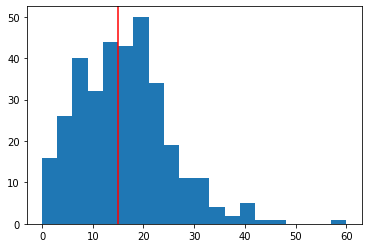

In [65]:
_ = plt.hist(tdc['cfb rec td'], bins = 20)
_ = plt.axvline(tdc['cfb rec td'].median(), color = 'r')

In [67]:
i = 0
cfbrtd_low = tdc[tdc['cfb rec td'] < tdc['cfb rec td'].median()][possible_targets[i]].dropna()
cfbrtd_high = tdc[tdc['cfb rec td'] >= tdc['cfb rec td'].median()][possible_targets[i]].dropna()
X = scipy.stats.ttest_ind(cfbrtd_low, cfbrtd_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb receiving tds'+
      '\nbelow and above the mean are from the same distribution'+
      '\nw.r.t. %s' %possible_targets[i]+
      '\nThe p-test for such hypothesis is p = %.8f \n' %X[1])

i = 1
cfbrtd_low = tdc[tdc['cfb rec td'] < tdc['cfb rec td'].median()][possible_targets[i]].dropna()
cfbrtd_high = tdc[tdc['cfb rec td'] >= tdc['cfb rec td'].median()][possible_targets[i]].dropna()
X = scipy.stats.ttest_ind(cfbrtd_low, cfbrtd_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb receiving tds'+
      '\nbelow and above the mean are from the same distribution'+
      '\nw.r.t. %s' %possible_targets[i]+
      '\nThe p-test for such hypothesis is p = %.8f \n' %X[1])

i = 2
cfbrtd_low = tdc[tdc['cfb rec td'] < tdc['cfb rec td'].median()][possible_targets[i]].dropna()
cfbrtd_high = tdc[tdc['cfb rec td'] >= tdc['cfb rec td'].median()][possible_targets[i]].dropna()
X = scipy.stats.ttest_ind(cfbrtd_low, cfbrtd_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb receiving tds'+
      '\nbelow and above the mean are from the same distribution'+
      '\nw.r.t. %s' %possible_targets[i]+
      '\nThe p-test for such hypothesis is p = %.8f \n' %X[1])

Null hypothesis: the samples of players with cfb receiving tds
below and above the mean are from the same distribution
w.r.t. nfl receptions per game
The p-test for such hypothesis is p = 0.00000127 

Null hypothesis: the samples of players with cfb receiving tds
below and above the mean are from the same distribution
w.r.t. nfl rec yards per game
The p-test for such hypothesis is p = 0.00000012 

Null hypothesis: the samples of players with cfb receiving tds
below and above the mean are from the same distribution
w.r.t. yards first 5 seasons
The p-test for such hypothesis is p = 0.00000060 

